In [9]:
%load_ext autoreload
%autoreload 2
import os
import sys
import torch
import random
import argparse
import numpy as np
import scipy
from matplotlib import pyplot
import numpy

sys.path.append('../../timeseries/')
sys.path.append('../../timeseries/experiments_scripts/')
sys.path.append('../../src/')

import factors
import state_models
import observation_models
from ssm_em import StateSpaceEM
from nonlinear_ssm import NonLinearStateSpace_EM

from scipy.stats import norm
from scipy.stats import zscore
from ssm_em import StateSpaceEM, load_model
from sklearn.covariance import EmpiricalCovariance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

from exp_utils import *

def reset_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_sunspots_e1()
t_tr = numpy.array([numpy.arange(x_tr.shape[0])]).T
t_va = numpy.array([numpy.arange(x_va.shape[0])]).T
t_te = numpy.array([numpy.arange(x_te.shape[0])]).T
x_tr, x_va, x_te = x_tr[:,:1], x_va[:,:1], x_te[:,:1]

In [60]:
from run_experiment import train_newt_gauss
newt_hsk = train_newt_gauss(x_tr)

NameError: name 'args' is not defined

In [61]:
predictions = newt_hsk.compute_predictive_density(x_te)

NameError: name 'args' is not defined

In [36]:
newt_hsk.compute_predictive_log_likelihood(x_te)

2246.9819417765566


-664.3177656170164

In [32]:
test_model = newt_hsk._train_test_model(x_te, t_te)

2246.9819417765566


In [52]:
dz, du = 1, 1
dx = x_tr.shape[1]
sm = state_models.LinearStateModel(dz)
om = observation_models.LinearObservationModel(dx, dz, noise_x=1.)

ssm_em_lin = StateSpaceEM(x_tr, observation_model=om, state_model=sm)
ssm_em_lin.run()

Iteration 2 - llk=-1163.8
Iteration 4 - llk=-729.2
Iteration 6 - llk=-641.1
Iteration 8 - llk=-631.9
Iteration 10 - llk=-630.3
EM did converge.


In [55]:
ssm_em_lin.compute_predictive_log_likelihood(X=x_te)

-735.9396562519788

In [56]:
- test_model.negative_log_predictive_density(t_te, x_te) * 1410 * 3

DeviceArray(109.7831547, dtype=float64)

In [59]:
test_model.compute_log_lik() / 4.

DeviceArray(-688.47423612, dtype=float64)

In [23]:
- .5 * np.sum(((x_te - predictions.mu) / predictions.Sigma) ** 2 + np.log(2 * np.pi * predictions.Sigma))

-664.3177656170164

In [57]:
test_model.energy()

DeviceArray(960.69086795, dtype=float64)

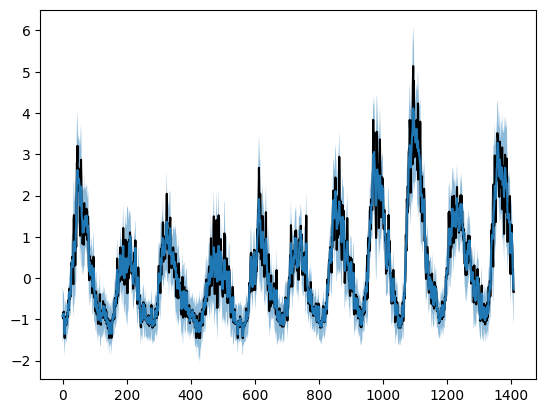

In [25]:
pyplot.rcdefaults()
mu = predictions.mu
lb, ub = mu - 1.96 * predictions.Sigma, mu + 1.96 * predictions.Sigma
pyplot.plot(x_te, 'k')
pyplot.plot(mu)
pyplot.fill_between(t_te[:,0], lb[:,0], ub[:,0], alpha=.5)

plotting ...


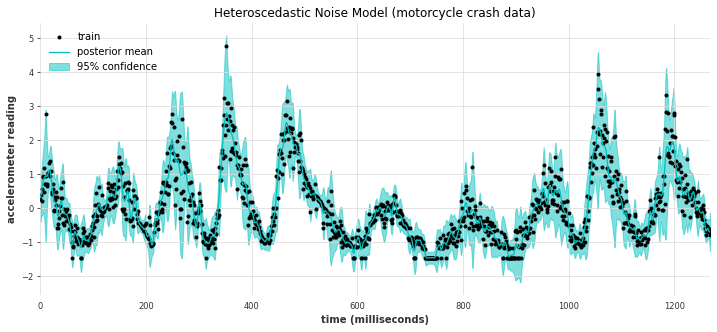

In [9]:
from matplotlib import pyplot as plt
posterior_mean, posterior_var = newt_hsk.model.predict(X=t_tr)

link = newt_hsk.model.likelihood.link_fn
lb = posterior_mean[:, 0] - np.sqrt(posterior_var[:, 0] + link(posterior_mean[:, 1]) ** 2) * 1.96
ub = posterior_mean[:, 0] + np.sqrt(posterior_var[:, 0] + link(posterior_mean[:, 1]) ** 2) * 1.96
post_mean = posterior_mean[:, 0]

print('plotting ...')
plt.figure(1, figsize=(12, 5))
plt.clf()
plt.plot(t_tr, x_tr[:,], 'k.', label='train')
plt.plot(t_tr, post_mean, 'c', label='posterior mean')
plt.fill_between(t_tr[:,0], lb, ub, color='c', alpha=0.5, label='95% confidence')
plt.xlim(t_tr[0], t_tr[-1])
plt.legend()
plt.title('Heteroscedastic Noise Model (motorcycle crash data)')
plt.xlabel('time (milliseconds)')
plt.ylabel('accelerometer reading')
plt.show()

In [38]:
import newt
import objax
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler

X = t_tr
Y = x_tr

# Standardize
Xall = X
Yall = Y
x_plot = np.linspace(np.min(Xall)-0.2, np.max(Xall)+0.2, 200)

# Load cross-validation indices

np.random.seed(123)
fold = 0


# Set training and test data
X = Xall
Y = Yall
N = X.shape[0]
M = 20
batch_size = N  # 100
Z = np.linspace(np.min(Xall), np.max(Xall), M)

var_f1 = 1.  # GP variance
len_f1 = 1.  # GP lengthscale
var_f2 = 1.  # GP variance
len_f2 = 1.  # GP lengthscale

kern1 = newt.kernels.Matern32(variance=var_f1, lengthscale=len_f1)
kern2 = newt.kernels.Matern32(variance=var_f2, lengthscale=len_f2)
kern = newt.kernels.Independent([kern1, kern2])
lik = newt.likelihoods.HeteroscedasticNoise()
#lik = newt.likelihoods.Gaussian()
# model = newt.models.VariationalGP(kernel=kern, likelihood=lik, X=X, Y=Y)
model = newt.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=X, Y=Y)
# model = newt.models.SparseExpectationPropagationGP(kernel=kern, likelihood=lik, X=X, Y=Y, Z=Z)

lr_adam = 0.01
lr_newton = 0.05
iters = 200
opt_hypers = objax.optimizer.Adam(model.vars())
energy = objax.GradValues(model.energy, model.vars())
inf_args = {
    "power": 0.5,  # the EP power
}


@objax.Function.with_vars(model.vars() + opt_hypers.vars())
def train_op():
    model.inference(lr=lr_newton, **inf_args)  # perform inference and update variational params
    dE, E = energy(**inf_args)  # compute energy and its gradients w.r.t. hypers
    opt_hypers(lr_adam, dE)
    return E

In [39]:
train_op = objax.Jit(train_op)

t0 = time.time()
for i in range(1, iters + 1):
    loss = train_op()
    print('iter %2d, energy: %1.4f' % (i, loss[0]))
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))

t0 = time.time()
posterior_mean, posterior_var = model.predict(X=x_plot)
nlpd = model.negative_log_predictive_density(X=X, Y=Y)
t1 = time.time()
print('prediction time: %2.2f secs' % (t1-t0))
print('NLPD: %1.2f' % nlpd)


x_pred = x_plot
link = model.likelihood.link_fn
lb = posterior_mean[:, 0] - np.sqrt(posterior_var[:, 0] + link(posterior_mean[:, 1]) ** 2) * 1.96
ub = posterior_mean[:, 0] + np.sqrt(posterior_var[:, 0] + link(posterior_mean[:, 1]) ** 2) * 1.96
post_mean = posterior_mean[:, 0]
lb = lb
ub = ub

iter  1, energy: 8497.0340
iter  2, energy: 8246.1744
iter  3, energy: 8066.2980
iter  4, energy: 7929.0332
iter  5, energy: 7819.3135
iter  6, energy: 7728.3375
iter  7, energy: 7650.6172
iter  8, energy: 7582.5629
iter  9, energy: 7521.7377
iter 10, energy: 7466.4381
iter 11, energy: 7415.4442
iter 12, energy: 7367.8641
iter 13, energy: 7323.0347
iter 14, energy: 7280.4553
iter 15, energy: 7239.7428
iter 16, energy: 7200.6006
iter 17, energy: 7162.7964
iter 18, energy: 7126.1466
iter 19, energy: 7090.5044
iter 20, energy: 7055.7518
iter 21, energy: 7021.7926
iter 22, energy: 6988.5480
iter 23, energy: 6955.9532
iter 24, energy: 6923.9537
iter 25, energy: 6892.5042
iter 26, energy: 6861.5661
iter 27, energy: 6831.1066
iter 28, energy: 6801.0975
iter 29, energy: 6771.5144
iter 30, energy: 6742.3362
iter 31, energy: 6713.5443
iter 32, energy: 6685.1223
iter 33, energy: 6657.0559
iter 34, energy: 6629.3320
iter 35, energy: 6601.9393
iter 36, energy: 6574.8675
iter 37, energy: 6548.1071
i

In [43]:
1269 * -.046

-58.374

plotting ...


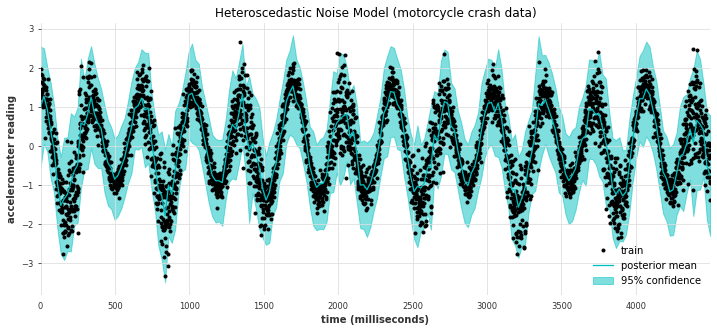

In [40]:
print('plotting ...')
plt.figure(1, figsize=(12, 5))
plt.clf()
plt.plot(X, Y[:,], 'k.', label='train')
plt.plot(x_pred, post_mean, 'c', label='posterior mean')
plt.fill_between(x_pred, lb, ub, color='c', alpha=0.5, label='95% confidence')
plt.xlim(x_pred[0], x_pred[-1])
plt.legend()
plt.title('Heteroscedastic Noise Model (motorcycle crash data)')
plt.xlabel('time (milliseconds)')
plt.ylabel('accelerometer reading')
plt.show()


In [7]:
model.likelihood.vars()

{}

In [6]:
var_f1 = model.kernel.kernel0.variance  # GP variance
len_f1 = model.kernel.kernel0.lengthscale  # GP lengthscale
var_f2 = model.kernel.kernel1.variance  # GP variance
len_f2 = model.kernel.kernel1.lengthscale  # GP lengthscale

kern1 = newt.kernels.Matern32(variance=var_f1, lengthscale=len_f1)
kern2 = newt.kernels.Matern32(variance=var_f2, lengthscale=len_f2)
kern = newt.kernels.Independent([kern1, kern2])
#lik = newt.likelihoods.HeteroscedasticNoise()
lik = newt.likelihoods.Gaussian()
lik.transformed_variance =  model.likelihood.transformed_variance
t_te = numpy.array([numpy.arange(x_te.shape[0])]).T
model_te = newt.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t_te, Y=x_te)


In [7]:
for i in range(10):
    _ = model_te.inference(lr=lr_newton, **inf_args)

In [10]:
std_te.shape, mean_te.shape, x_te.shape

((5000, 2), (5000, 2), (5000, 1))

In [25]:
mean_te, std_te = posterior_mean, posterior_var = model_te.predict_y(t_te)
lb, ub = mean_te - 1.96 * std_te, mean_te + 1.96 * std_te

In [26]:
mean_te.shape, t_te.shape

((5000, 2), (5000, 1))

plotting ...


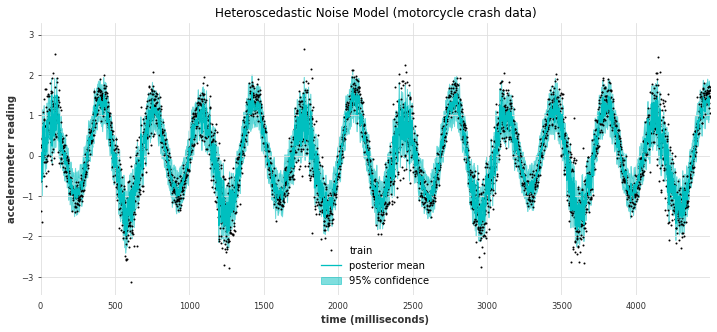

In [12]:
print('plotting ...')
plt.figure(1, figsize=(12, 5))
plt.clf()
plt.plot(t_te, x_te[:,0], 'k.', label='train', ms=2)
plt.plot(t_te, mean_te[:,1], 'c', label='posterior mean')
plt.fill_between(t_te[:,0], lb[:,0], ub[:,0], color='c', alpha=0.5, label='95% confidence')
plt.xlim(x_pred[0], x_pred[-1])
plt.legend()
plt.title('Heteroscedastic Noise Model (motorcycle crash data)')
plt.xlabel('time (milliseconds)')
plt.ylabel('accelerometer reading')
plt.show()


plotting ...


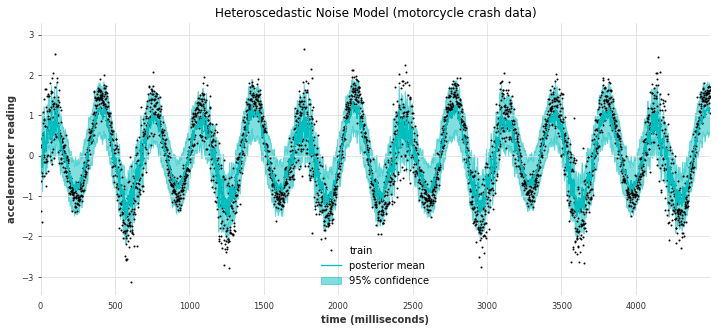

In [28]:
print('plotting ...')
plt.figure(1, figsize=(12, 5))
plt.clf()
plt.plot(t_te, x_te[:,0], 'k.', label='train', ms=2)
plt.plot(t_te, mean_te[:,0], 'c', label='posterior mean')
plt.fill_between(t_te[:,0], lb[:,0], ub[:,0], color='c', alpha=0.5, label='95% confidence')
plt.xlim(x_pred[0], x_pred[-1])
plt.legend()
plt.title('Heteroscedastic Noise Model (motorcycle crash data)')
plt.xlabel('time (milliseconds)')
plt.ylabel('accelerometer reading')
plt.show()


plotting ...


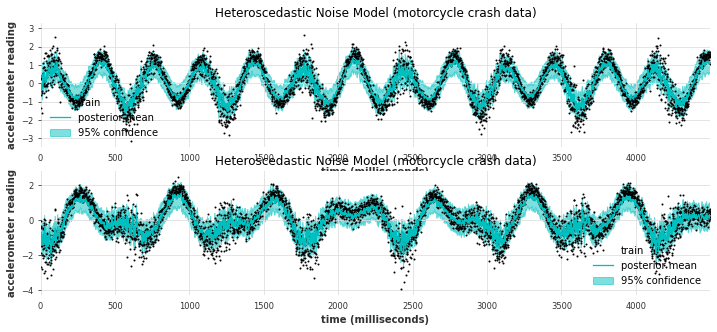

In [29]:
idx = 1
print('plotting ...')
plt.figure(1, figsize=(12, 5))
plt.clf()
for idx in range(2):
    plt.subplot(2,1,idx + 1)
    plt.plot(t_te, x_te[:,idx], 'k.', label='train', ms=2)
    plt.plot(t_te, mean_te[:,idx], 'c', label='posterior mean')
    plt.fill_between(t_te[:,0], lb[:,idx], ub[:,idx], color='c', alpha=0.5, label='95% confidence')
    plt.xlim(x_pred[0], x_pred[-1])
    plt.legend()
    plt.title('Heteroscedastic Noise Model (motorcycle crash data)')
    plt.xlabel('time (milliseconds)')
    plt.ylabel('accelerometer reading')
plt.show()


In [47]:
class PredictiveDensity:
    
    def __init__(self, mu, sigma):
        self.mu = np.array(mu)
        self.sigma = np.array(sigma)
prediction = PredictiveDensity(mean_te, std_te)
prediction.mu

array([[-0.21322005, -0.37518134],
       [-0.25958397, -0.52920327],
       [-0.2269161 , -0.51692111],
       ...,
       [-0.57599973,  0.55536022],
       [-0.51371086,  0.53008934],
       [-0.41227597,  0.4537489 ]])

In [53]:
float(model_te.compute_log_lik())

-15363.388842242908

In [60]:
model_te

4

In [61]:
mean_tr.shape

(4500, 2)

In [49]:
x_te, x_tr

(array([[-0.25152037],
        [-1.36332874],
        [-0.19721854],
        ...,
        [-1.22441217],
        [-1.13327758],
        [-1.05721411]]),
 array([[ 1.29459601,  0.24436796],
        [ 1.9665759 , -0.36096954],
        [ 1.0739167 , -0.19596192],
        ...,
        [-0.24158867, -0.11605155],
        [-0.90590849,  0.40698343],
        [-1.37342586, -1.79604379]]))

In [30]:
x_tr.ndim

2

In [33]:
numpy.array([[1,2]]).shape

(1, 2)